In [ ]:
!pip install easyfsl

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import list_dir, list_files

import os
from tqdm import tqdm
from PIL import Image
from os.path import join
from typing import Any, Callable, List, Optional, Tuple

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [2]:
colorMode = "RGB"   # Color = 'RGB' || Grayscale = 'L'
datasetFolder = "./data"
image_size = 128

N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

N_TRAINING_EPISODES = 40000     # Number of tasks to sample during training
N_VALIDATION_TASKS = 100        # Number of tasks to sample during validation

In [3]:
#Custom Plant Village Dataset Class

class PV(VisionDataset):

    folder = "PlantVillage"

    def __init__(
        self,
        root: str,
        background: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(join(root, self.folder), transform=transform, target_transform=target_transform)
        self.background = background

        self.target_folder = join(self.root, self._get_target_folder())
        self._alphabets = list_dir(self.target_folder)
        self._characters: List[str] = sum(
            ([join(a, c) for c in list_dir(join(self.target_folder, a))] for a in self._alphabets), []
        )
        self._character_images = [
            [(image, idx) for image in list_files(join(self.target_folder, character), ".JPG")]
            for idx, character in enumerate(self._characters)
        ]
        self._flat_character_images: List[Tuple[str, int]] = sum(self._character_images, [])

    def __len__(self) -> int:
        return len(self._flat_character_images)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image_name, character_class = self._flat_character_images[index]
        image_path = join(self.target_folder, self._characters[character_class], image_name)
        image = Image.open(image_path, mode="r").convert(colorMode)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            character_class = self.target_transform(character_class)

        return image, character_class

    def _get_target_folder(self) -> str:
        return "images_background" if self.background else "images_evaluation"

In [4]:
# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = PV(
    root=datasetFolder,
    background=True,
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
test_set = PV(
    root=datasetFolder,
    background=False,
    transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.ToTensor(),
        ]
    ),
)

In [5]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(weights='ResNet18_Weights.DEFAULT')
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

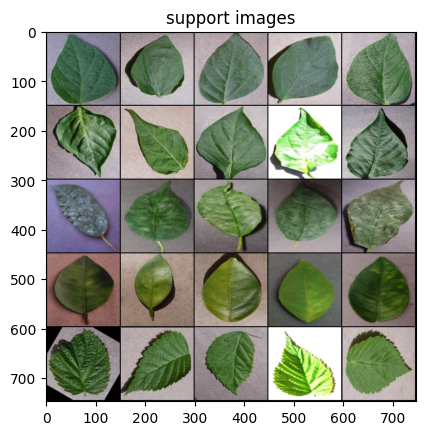

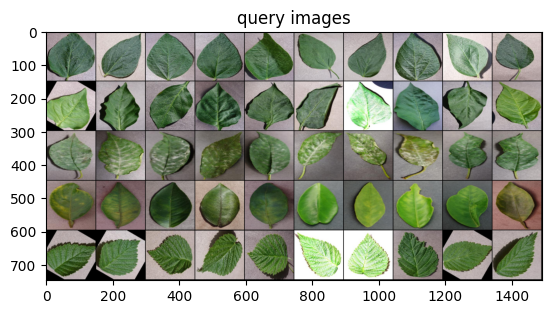

In [7]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [8]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Cherry/Cherry_(including_sour)__Powdery_mildew
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Soybean/Soybean__healthy / Papper/Pepper__healthy
Soybean/Soybean__healthy / Soybean/Soybean__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Orange/Orange__Haunglongbing_(Citrus_greening)
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Papper/Pepper__healthy
Papper/Pepper__healthy / Pa

In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:02<00:00, 34.73it/s]

Model tested on 100 tasks. Accuracy: 84.38%


In [10]:
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [24:48<00:00, 26.87it/s, loss=0.122] 


In [13]:
evaluate(test_loader)

100%|██████████| 100/100 [00:02<00:00, 36.48it/s]

Model tested on 100 tasks. Accuracy: 80.78%


In [17]:
#Save Model
'''
import time
PATH = "./model-saves/"+"5-way 5-shot Plant RGB "+time.strftime("%Y-%m-%d-%H%M%S")
torch.save(model, PATH)
'''

In [15]:
#Load Model

#model = torch.load("./saves/20230929-164939")